# CI Portfolio Project 5 - Filter Maintenance Predictor 2022
## **Data Cleaning Notebook**

## Objectives


* Clean data in preparation for analysis
* Create Total dataset
* Extend Data_No references
* Determine Correlations
* Manage Missing Data
* Review Outliers

### Inputs

* Total Dataset : `outputs/datasets/collection/PredictiveMaintenanceTotal.csv`

### Outputs

* Generate a cleaned **df_total** dataset saved under `outputs/datasets/cleaned`

### Conclusions: 
* No missing data
* Data clean and organized in preparation for analysis
    * Missing data: **None**
    * Inconsistencies found: **None**
    * Fixes applied to incorrect data: **None**

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

# Load Collection Data

In [4]:
import pandas as pd

df_train = pd.read_csv(f'outputs/datasets/collection/PredictiveMaintenanceTrain.csv')
df_test = pd.read_csv(f'outputs/datasets/collection/PredictiveMaintenanceTest.csv')

In [5]:
df_train.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
0,1,0.0,0.0,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust"
1,1,0.0,0.0,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust"
2,1,0.0,0.0,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust"
3,1,0.0,0.0,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust"
4,1,0.0,0.0,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust"


In [6]:
df_test.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


---

# Data Exploration and Cleaning

## Extend `Data_No` variable
A comparison between sets reveals that the **Data_No** variable:
* Is a categorical variable presented as an integer
* Restarts at the beginning of each dataset

This has the potential to confound subsequent analysis between the sets, where the analysis erroneously considers *Data_No* a discrete value &/or a duplicate entry. To help avoid confusion we alter the values in the **df_test dataset** to be a continuation from the bins seen in the **df_train dataset**.

This is as simple as adding the total number of unique test bins in the df_test set to each one seen in the df_train set:

Calculate the total number of test sets in **df_train**

In [7]:
duplicates = df_train.pivot_table(index=['Data_No'], aggfunc='size')
df_train_total_sets = duplicates.count()
df_train_total_sets

50

Continue the numbering in the next set : **df_test**

In [8]:
new_data_no = df_test['Data_No'] + df_train_total_sets
new_data_no

0         51
1         51
2         51
3         51
4         51
        ... 
39409    100
39410    100
39411    100
39412    100
39413    100
Name: Data_No, Length: 39414, dtype: int64

Replace new data references into **df_test**

In [9]:
df_test['Data_No'] = new_data_no
df_test

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,51,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,51,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,51,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,51,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,51,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5
...,...,...,...,...,...,...,...
39409,100,465.494800,82.675521,52.0,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.2
39410,100,464.228900,82.421873,52.1,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.1
39411,100,466.037300,82.743156,52.2,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.0
39412,100,472.276500,82.785427,52.3,316.985065,"ISO 12103-1, A4 Coarse Test Dust",7.9


## Create **df_total** for ease of engineering

Before we continue, managing two datasets has the potential to double the workload when adding / engineering data. In the spirit of doing things once, there is value to combining the supplied datasets into one **df_total** set to work with, and split once we are happy with the cleaning and engineering stages.

Combine the **df_test** & **df_train** into **df_total**

In [10]:
df_total = pd.concat([df_train, df_test], ignore_index=True)
df_total

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.0000,0.000000,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
1,1,0.0000,0.000000,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
2,1,0.0000,0.000000,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
3,1,0.0000,0.000000,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
4,1,0.0000,0.000000,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
...,...,...,...,...,...,...,...
78829,100,465.4948,82.675521,52.0,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.2
78830,100,464.2289,82.421873,52.1,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.1
78831,100,466.0373,82.743156,52.2,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.0
78832,100,472.2765,82.785427,52.3,316.985065,"ISO 12103-1, A4 Coarse Test Dust",7.9


Confirm we can recall the **df_test** & **df_train** datasets as needed

In [11]:
data_no_total = df_total['Data_No'].map(int).round(decimals=0)
df_total['Data_No'] = data_no_total
n = df_total['Data_No'][0:len(df_total)]
df_train = df_total[n < 51].reset_index(drop=True)
df_test = df_total[n > 50].reset_index(drop=True)
del df_train['RUL']
df_train

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
0,1,0.0000,0.000000,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust"
1,1,0.0000,0.000000,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust"
2,1,0.0000,0.000000,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust"
3,1,0.0000,0.000000,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust"
4,1,0.0000,0.000000,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust"
...,...,...,...,...,...,...
39415,50,359.9718,58.721877,59.4,177.321707,"ISO 12103-1, A4 Coarse Test Dust"
39416,50,360.7856,58.699919,59.5,177.321707,"ISO 12103-1, A4 Coarse Test Dust"
39417,50,361.5090,58.743820,59.6,177.321707,"ISO 12103-1, A4 Coarse Test Dust"
39418,50,362.0515,58.601152,59.7,177.321707,"ISO 12103-1, A4 Coarse Test Dust"


In [12]:
df_test

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,51,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,51,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,51,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,51,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,51,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5
...,...,...,...,...,...,...,...
39409,100,465.494800,82.675521,52.0,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.2
39410,100,464.228900,82.421873,52.1,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.1
39411,100,466.037300,82.743156,52.2,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.0
39412,100,472.276500,82.785427,52.3,316.985065,"ISO 12103-1, A4 Coarse Test Dust",7.9


## Correlation and Power Predictive Score Analysis

Following code derived from Code Institute [Exploratory Data Analysis Tools](https://learn.codeinstitute.net/courses/course-v1:CodeInstitute+DDA101+2021_T4/courseware/468437859a944f7d81a34234957d825b/c8ea2343476c48739676b7f03ba9b08e/) 2022.

In [13]:
import numpy as np
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(10, 8), font_annot=8):
    """
    Heatmap for pearson (linear) and spearman (monotonic) correlations to 
    visualize only those correlation levels greater than a given threshold.
    """
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={'size': font_annot}, ax=axes,
                    linewidth=0.01, linecolor='WhiteSmoke'
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(10, 8), font_annot=8):
    """
    Heatmap for power predictive score
    PPS == 0 means that there is no predictive power
    PPS < 0.2 often means that there is some relevant predictive power but it is weak
    PPS > 0.2 often means that there is strong predictive power
    PPS > 0.8 often means that there is a deterministic relationship in the data,
    """
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={'size': font_annot},
                         linewidth=0.01, linecolor='WhiteSmoke')
        plt.ylim(len(df.columns), 0)
        plt.show()


def calculate_corr_and_pps(df):
    """
    Calculate the correlations and ppscore of a given dataframe
    """
    df_corr_spearman = df.corr(method='spearman')
    df_corr_pearson = df.corr(method='pearson')

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query('ppscore < 1').filter(['ppscore']).describe().T
    print('PPS threshold - check PPS score IQR to decide threshold for heatmap \n')
    print(pps_score_stats.round(4))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def display_corr_and_pps(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(10, 8), font_annot=8):
    """
    Render the correlations and ppscore heatmaps for a given dataframe
    """
    print('To analyze: \n** Colinearity: how the target variable is correlated with the other features (variables)')
    print('** Multi-colinearity: how each feature correlates among themselves (multi-colinearity)')

    print('\n')
    print('*** Heatmap: Pearson Correlation ***')
    print(f'It evaluates the linear relationship between two continuous variables \n'
          f'* A +ve correlation indicates that as one variable increases the other variable tends to increase.\n'
          f'A correlation near zero indicates that as one variable increases, there is no tendency in the other variable to either increase or decrease.\n'
          f'A -ve correlation indicates that as one variable increases the other variable tends to decrease.')
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print('\n')
    print(f'*** Heatmap: Spearman Correlation ***')
    print(f'It evaluates monotonic relationship \n'
          f'Spearman correlation coefficients range from -1 to +1.\n'
          f'The sign of the coefficient indicates whether it is a positive or negative monotonic relationship.\n'
          f'* A positive correlation means that as one variable increases, the other variable also tends to increase.')
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print('\n')
    print('*** Heatmap: Power Predictive Score (PPS) ***')
    print(f'PPS detects linear or non-linear relationships between two columns.\n'
          f'The variable on the x-axis is used to predict the corresponding variable on the y-axis.\n'
          f'The score ranges from 0 (no predictive power) to 1 (perfect predictive power)\n\n'
          f'* PPS == 0 means that there is no predictive power\n'
          f'* PPS < 0.2 often means that there is some relevant predictive power but it is weak\n'
          f'* PPS > 0.2 often means that there is strong predictive power\n'
          f'* PPS > 0.8 often means that there is a deterministic relationship in the data\n')
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

#### Drop Categorical Variables, Calculate Correlations and Power Predictive Score

In [14]:
df_drop = df_total.drop(['Data_No'], axis=1)
df_corr_pearson, df_corr_spearman, pps_matrix = calculate_corr_and_pps(df_drop)

/tmp/ipykernel_2598/2963152569.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_spearman = df.corr(method='spearman')
/tmp/ipykernel_2598/2963152569.py:48: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_pearson = df.corr(method='pearson')


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count    mean     std  min  25%     50%     75%     max
ppscore   30.0  0.0936  0.1095  0.0  0.0  0.0463  0.1776  0.3794


**Pairplot** to visualize the relationships among the provided variables

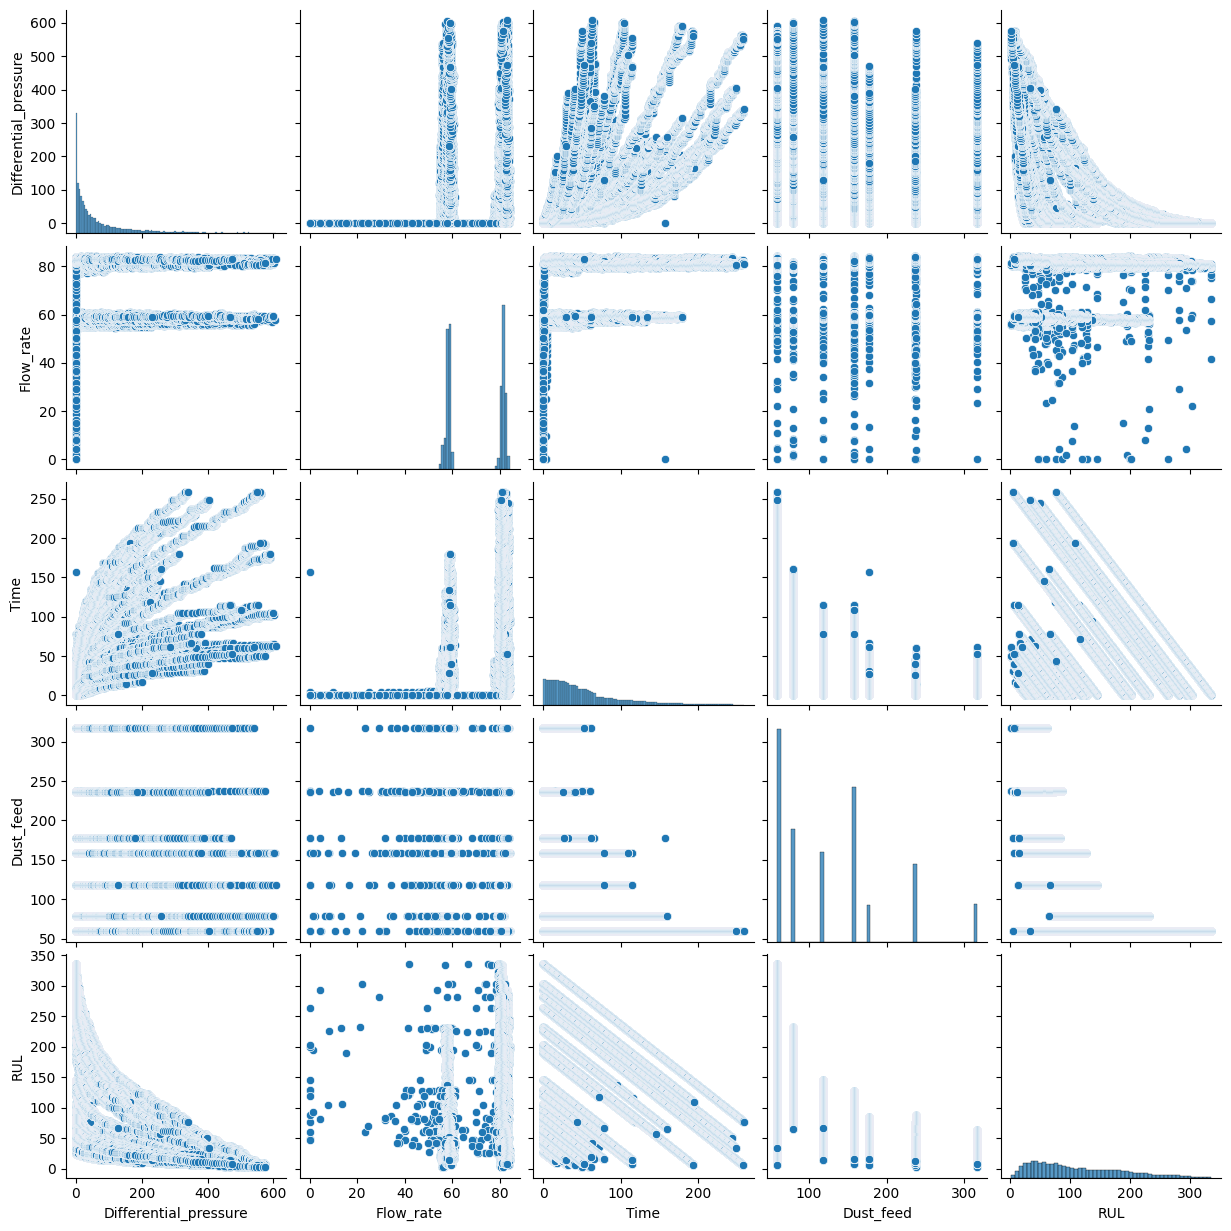

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data=df_drop)
plt.show()

With a quick look, we notice relationships between `differential_pressure`, `RUL` and `Time`.

#### Heatmaps for **df_total** dataset

To analyze: 
** Colinearity: how the target variable is correlated with the other features (variables)
** Multi-colinearity: how each feature correlates among themselves (multi-colinearity)


*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 
* A +ve correlation indicates that as one variable increases the other variable tends to increase.
A correlation near zero indicates that as one variable increases, there is no tendency in the other variable to either increase or decrease.
A -ve correlation indicates that as one variable increases the other variable tends to decrease.


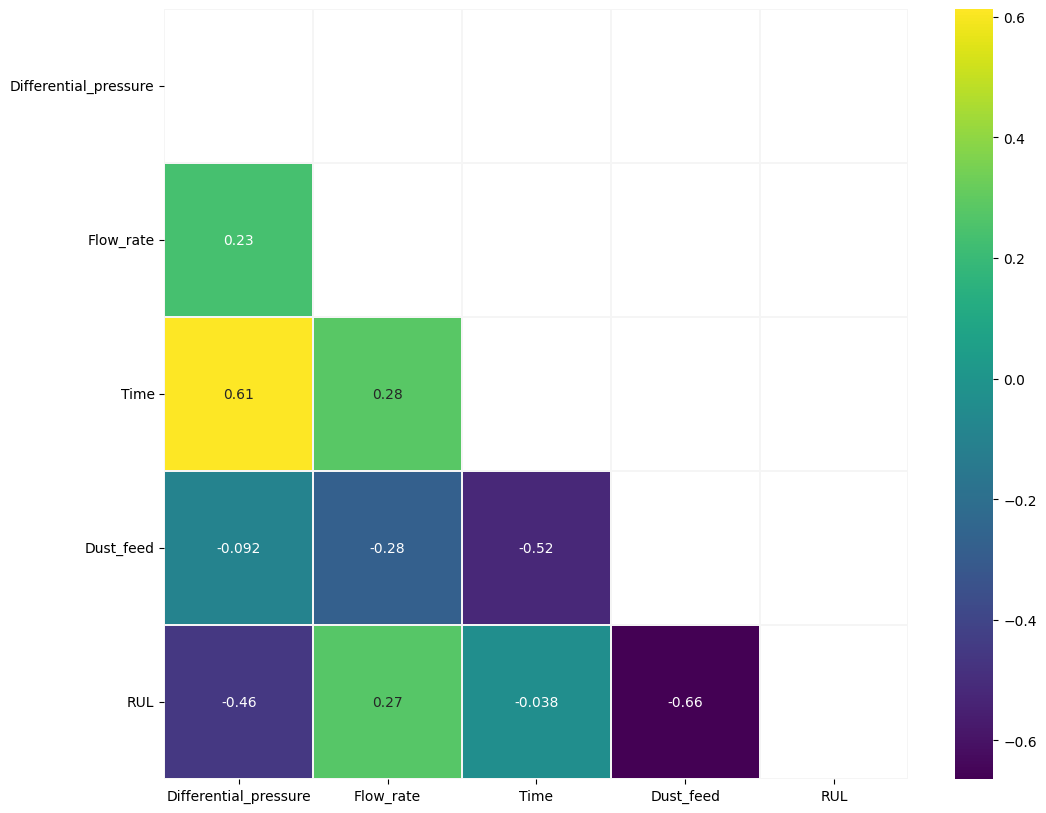



*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 
Spearman correlation coefficients range from -1 to +1.
The sign of the coefficient indicates whether it is a positive or negative monotonic relationship.
* A positive correlation means that as one variable increases, the other variable also tends to increase.


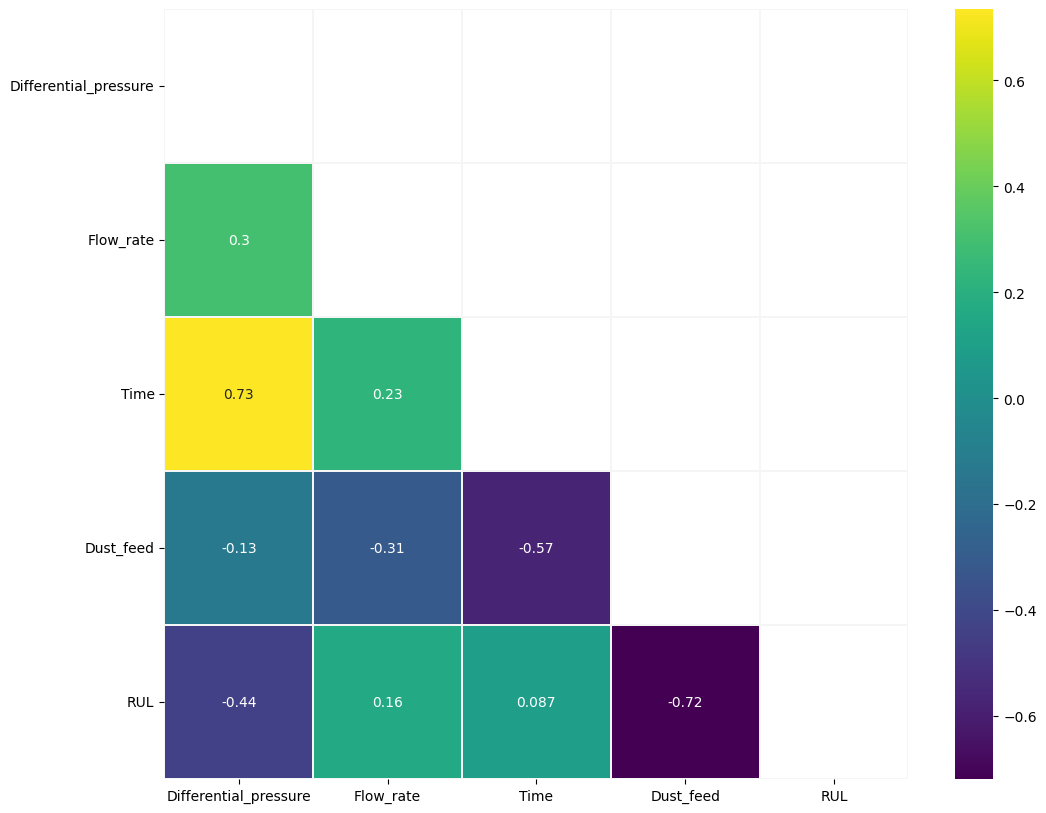



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The variable on the x-axis is used to predict the corresponding variable on the y-axis.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power)

* PPS == 0 means that there is no predictive power
* PPS < 0.2 often means that there is some relevant predictive power but it is weak
* PPS > 0.2 often means that there is strong predictive power
* PPS > 0.8 often means that there is a deterministic relationship in the data



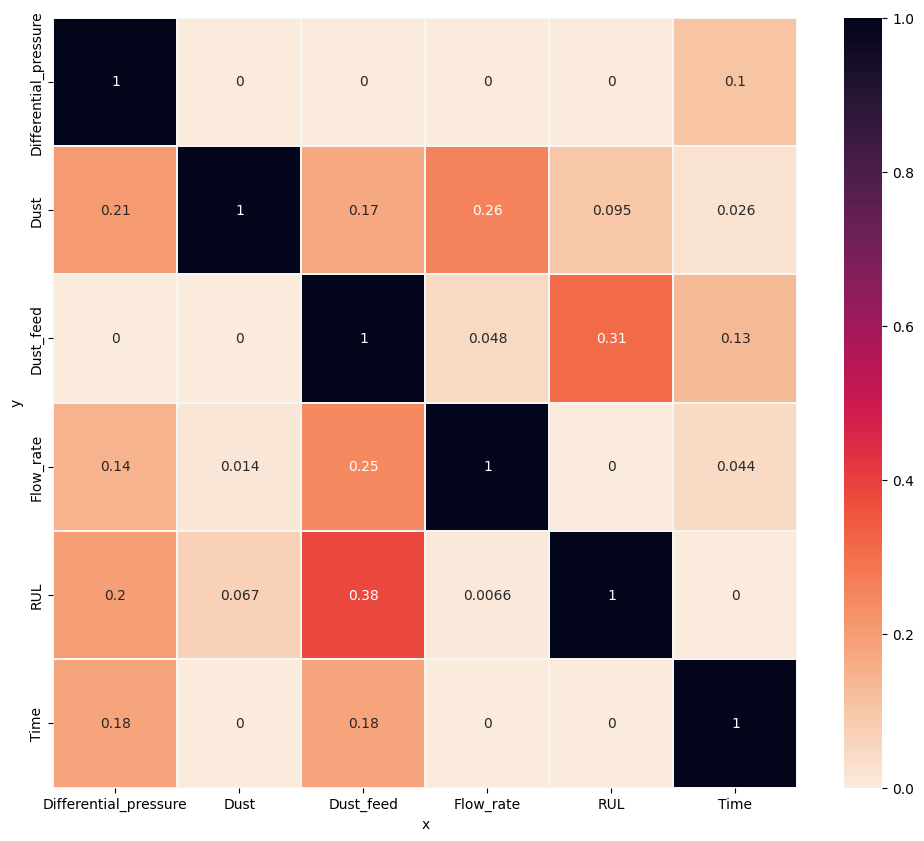

In [16]:
display_corr_and_pps(df_corr_pearson = df_corr_pearson, df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix, CorrThreshold = 0, PPS_Threshold =0,
                    figsize=(12,10), font_annot=10
                    )

### Observations
#### Heatmap: **Pearson Correlation**
* A linear relationship is one when a change in one variable is associated with a proportional change in the other variable 
* Positive relationships can be observed between 
    * **Differential Pressure** and **Time** plus **Flow Rate** with a negative 
    * **Flow Rate** and **RUL** plus **Time** 
* Strongly negative between **Differential Pressure** and **RUL** 

#### Heatmap: **Spearman Correlation**
* A monotonic relationship is one where one variable is associated with a **change in the specific direction** of another variable. 
    * e.g. Does a positive change in value/direction X result in a positive change in the value/direction of Y?
    * We consider Spearman’s correlation when 
        * we have pairs of continuous variables and the relationships between them don’t follow a straight line (curvilinear), and/or 
        * we have pairs of ordinal data (like time)

* **Spearman's rho Values and Direction**
    * **Differential Pressure** is strongly positively correlated to **Time**, less so **Flow Rate** and negatively correlated to **RUL**
    * **Dust Feed** is negatively correlated to **RUL** whereas **Dust Type** is positively correlated to **RUL**
    * **Flow Rate** is positively correlated to **Time** and **Differential Pressure** as noted above.

#### Heatmap: **Power Predictive Score (PPS)**
* Detects linear or non-linear relationships between two columns.
* We see strong predictive power between **Dust_feed** and **RUL**, less so however still significant with **Dust_feed** and **Flow_rate**
    * RUL as a calculation of **time** remaining, is logically affected by the volume of dust per second. The lower the flow or feed, the higher the RUL. This is however dictated by the simple fact that the filter needs to filter dust. Reducing either of the rates naturally negates the purpose of the filtering process, so we will treat it as a **confounding** relationship and as such, cannot be described in terms of correlations or associations.
* When considering the absolute levels of the scores in the dataset, we see a weak yet strong predictive relationship between **Differential Pressure** and **RUL**
    * Differential pressure has predictive power of RUL, whereas RUL has no predictive power on differential pressure
    * Naturally we also see a week two way relationship between  **Differential Pressure** and **Time**


## Missing Data
To review variables than RUL with missing data and discover their distribution and shape.

Define a function to review missing data

In [17]:
def EvaluateMissingData(df):
    """
    Looks across dataset to find null 
    """
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )
    return df_missing_data

Review the **df_total** dataset

In [18]:
vars_with_missing_data = EvaluateMissingData(df_total)
print(f"* There are {vars_with_missing_data.shape[0]} variables with missing data")
vars_with_missing_data

* There are 1 variables with missing data


,RowsWithMissingData,PercentageOfDataset,DataType
RUL,39420,50.0,float64


As the **df_train** dataset is supplied without values for `RUL`, we can extract the **df_test** set checked separately to confirm the function

In [19]:
data_no_total = df_total['Data_No'].map(int).round(decimals=0)
df_total['Data_No'] = data_no_total
n = df_total['Data_No'][0:len(df_total)]
df_train = df_total[n < 51].reset_index(drop=True)
df_test = df_total[n > 50].reset_index(drop=True)
del df_train['RUL']

Check for missing data and return a **Pandas Profile Report** on the variable with missing 

In [20]:
from pandas_profiling import ProfileReport

def name_dataframe(data):
    """ To identify which dataframe is being accessed """
    name =[n for n in globals() if globals()[n] is data][0]
    print('Dataframe name: %s' % name)

for df in (df_train, df_test):
    vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
    if vars_with_missing_data:
        profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
        profile.to_notebook_iframe()
    else:
        name_dataframe(df)
        print('There are no variables with missing data')

Dataframe name: df_train
There are no variables with missing data
Dataframe name: df_test
There are no variables with missing data


## Outliers in differential pressure observations

In each bin we notice fluctuations in the **differential pressures** measure. These may be considered outliers as the pressure gradient across the filter needs time to stabilize. We have considered three main methods to deal with these observations:
* Log transformation
* Winsorize method
* Dropping the outliers

These will be handled in the [feature engineering](https://github.com/roeszler/filter-maintenance-predictor/blob/main/jupyter_notebooks/03_FeatureEngineering.ipynb) notebook

In [21]:
df_total[df_total['Data_No'] == 96]

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
75134,96,0.0000,50.196716,0.1,237.738799,"ISO 12103-1, A2 Fine Test Dust",27.1
75135,96,0.0000,70.261003,0.2,237.738799,"ISO 12103-1, A2 Fine Test Dust",27.0
75136,96,0.0000,78.937847,0.3,237.738799,"ISO 12103-1, A2 Fine Test Dust",26.9
75137,96,0.0000,80.760268,0.4,237.738799,"ISO 12103-1, A2 Fine Test Dust",26.8
75138,96,0.0000,81.830035,0.5,237.738799,"ISO 12103-1, A2 Fine Test Dust",26.7
...,...,...,...,...,...,...,...
75279,96,145.3993,82.912251,14.6,237.738799,"ISO 12103-1, A2 Fine Test Dust",12.6
75280,96,148.0216,83.164562,14.7,237.738799,"ISO 12103-1, A2 Fine Test Dust",12.5
75281,96,149.2875,83.427798,14.8,237.738799,"ISO 12103-1, A2 Fine Test Dust",12.4
75282,96,149.1971,83.582107,14.9,237.738799,"ISO 12103-1, A2 Fine Test Dust",12.3


---

# Save Datasets

In [22]:
df_total

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.0000,0.000000,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
1,1,0.0000,0.000000,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
2,1,0.0000,0.000000,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
3,1,0.0000,0.000000,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
4,1,0.0000,0.000000,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",NaN
...,...,...,...,...,...,...,...
78829,100,465.4948,82.675521,52.0,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.2
78830,100,464.2289,82.421873,52.1,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.1
78831,100,466.0373,82.743156,52.2,316.985065,"ISO 12103-1, A4 Coarse Test Dust",8.0
78832,100,472.2765,82.785427,52.3,316.985065,"ISO 12103-1, A4 Coarse Test Dust",7.9


Save the files to /cleaned folder

In [23]:
import os
import shutil

try:
    shutil.rmtree('outputs/datasets/cleaned')
    shutil.rmtree('deployed/')
except Exception as e:
  print(e)

try:
    os.makedirs(name='outputs/datasets/cleaned')
    os.makedirs(name='deployed/')
except Exception as e:
  print(e)

df_total.to_csv(f'outputs/datasets/cleaned/dfCleanTotal.csv',index=False)
df_total.to_csv(f'deployed/dfCleanTotal.csv',index=False)

---

# Conclusions and Next steps

#### Observations:
* Possible relationships to consider:
    * **Differential Pressure**, **Time**, **RUL**
    * **Dust Feed, Flow and Type** to **RUL**

#### Conclusions: 
* No missing data
* Data clean and organized in preparation for analysis
    * Missing data: **RUL from Train Data**
    * Inconsistencies found: **None**
    * Fixes applied to incorrect data: **None**
* Remaining Useful Life can be accurately calculated from Remaining Filter Balance, Time and/or Total Time parameters. 

#### Next Steps:
* Correlation Study
* Feature Engineering
    * Additional calculations to add interpretative value to the datasets
    * Confirm RUL calculation methodology

---